# **Imports**

In [1]:
!pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# XGBoost
from xgboost import XGBClassifier

# Unsupervised methods
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# For saving models
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("All imports complete.")


All imports complete.


# **Load Metadata & Raw Liver Data**

In [5]:
# Load liver metadata from "liver.txt"
metadata_file_path = "/content/liver.txt"
liver_column_names = []
with open(metadata_file_path, 'r') as file:
    next(file)  # Skip header line if present
    for line in file:
        parts = line.split('\t')
        if len(parts) > 1:
            liver_column_names.append(parts[1].strip())
print(f"Extracted {len(liver_column_names)} column names from liver metadata.")

# Load the raw liver data.
# (Assumed to be a tab-delimited file. Adjust file path if needed.)
liver_data_file_path = "/content/LIVER_DATA.DAT"
liver_raw = pd.read_csv(liver_data_file_path, sep='\t', header=None, engine='python')

# Assign column names (if available).
if len(liver_column_names) >= liver_raw.shape[1]:
    liver_raw.columns = liver_column_names[:liver_raw.shape[1]]
else:
    print("Warning: Not enough column names for all liver data columns.")

print("Raw liver data shape:", liver_raw.shape)


Extracted 416 column names from liver metadata.
Raw liver data shape: (54266, 416)


# **Data Cleaning & Preprocessing for Liver Data**

In [6]:
# Replace dot values ('.') with NaN.
liver_raw.replace(".", np.nan, inplace=True)

# Convert columns that contain 'DATE' or 'DT' to datetime.
liver_date_cols = [col for col in liver_raw.columns if col and ('DATE' in col.upper() or 'DT' in col.upper())]
for col in liver_date_cols:
    liver_raw[col] = pd.to_datetime(liver_raw[col], format='%m/%d/%Y', errors='coerce')

# Drop columns with >80% missing values.
liver_missing_percentage = liver_raw.isnull().mean() * 100
liver_cols_to_drop = liver_missing_percentage[liver_missing_percentage > 80].index.tolist()
print(f"Number of liver columns to drop (>80% missing): {len(liver_cols_to_drop)}")
liver_cleaned = liver_raw.drop(columns=liver_cols_to_drop)
print("Liver data shape after dropping high-missing columns:", liver_cleaned.shape)

# Impute remaining missing values:
# Numeric columns: fill with median.
# Categorical columns: fill with mode.
liver_imputed = liver_cleaned.copy()
liver_numeric_cols = liver_imputed.select_dtypes(include=['float64', 'int64']).columns
liver_categorical_cols = liver_imputed.select_dtypes(include=['object']).columns

for col in liver_numeric_cols:
    if liver_imputed[col].isnull().any():
        liver_imputed[col].fillna(liver_imputed[col].median(), inplace=True)
for col in liver_categorical_cols:
    if liver_imputed[col].isnull().any():
        liver_imputed[col].fillna(liver_imputed[col].mode()[0], inplace=True)

print("Total missing values in liver data after imputation:", liver_imputed.isnull().sum().sum())


<ipython-input-6-c0829f94740f>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  liver_raw.replace(".", np.nan, inplace=True)


Number of liver columns to drop (>80% missing): 189
Liver data shape after dropping high-missing columns: (54266, 227)


<ipython-input-6-c0829f94740f>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  liver_imputed[col].fillna(liver_imputed[col].median(), inplace=True)
<ipython-input-6-c0829f94740f>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Total missing values in liver data after imputation: 123122


# **Define Outcome Variable for Liver Transplant Success**

In [7]:
# We define "Transplant_Success" as 1 if COMPOSITE_DEATH_DATE is null (patient alive at follow‑up), 0 otherwise.
if 'COMPOSITE_DEATH_DATE' in liver_imputed.columns:
    liver_imputed['Transplant_Success'] = liver_imputed['COMPOSITE_DEATH_DATE'].isnull().astype(int)
    print("Liver Transplant_Success value counts:")
    print(liver_imputed['Transplant_Success'].value_counts())
else:
    print("COMPOSITE_DEATH_DATE column not found in liver data. Please verify your data.")


Liver Transplant_Success value counts:
Transplant_Success
0    35265
1    19001
Name: count, dtype: int64


# **Unsupervised Clustering for Liver – Derive "Liver_Cluster"**

In [9]:
# Before clustering, keep track of the indices to map clusters back correctly
X_liver_candidate = liver_imputed[available_liver_features].copy()

# Convert appropriate columns to numeric
for col in ['INIT_AGE', 'BMI_TCR', 'DAYSWAIT_CHRON']:
    if col in X_liver_candidate.columns:
        X_liver_candidate[col] = pd.to_numeric(X_liver_candidate[col], errors='coerce')

# Convert categorical variables to one-hot encoding
if 'GENDER' in X_liver_candidate.columns:
    X_liver_candidate = pd.get_dummies(X_liver_candidate, columns=['GENDER'], drop_first=True)

if 'ABO' in X_liver_candidate.columns:
    X_liver_candidate = pd.get_dummies(X_liver_candidate, columns=['ABO'], drop_first=True)

if 'HCC_DIAGNOSIS_TCR' in X_liver_candidate.columns:
    X_liver_candidate = pd.get_dummies(X_liver_candidate, columns=['HCC_DIAGNOSIS_TCR'], drop_first=True)

# Create a copy of the indices before deduplication
original_indices = X_liver_candidate.index.copy()

# Store a mapping of duplicated rows to their first occurrence
duplicated_mapping = {}
seen_rows = set()
for idx, row_tuple in enumerate(X_liver_candidate.itertuples(index=True)):
    # Convert row to a hashable representation (excluding index)
    row_values = tuple(row_tuple[1:])
    if row_values in seen_rows:
        # This is a duplicate, mark it
        duplicated_mapping[row_tuple.Index] = row_values
    else:
        seen_rows.add(row_values)

# Drop duplicates
X_liver_candidate = X_liver_candidate.drop_duplicates()
print("Liver candidate features shape after deduplication:", X_liver_candidate.shape)

# Scale the liver candidate features
scaler_liver = StandardScaler()
X_liver_candidate_scaled = scaler_liver.fit_transform(X_liver_candidate)
X_liver_candidate_scaled_df = pd.DataFrame(X_liver_candidate_scaled, columns=X_liver_candidate.columns, index=X_liver_candidate.index)

# For computational efficiency, sample a subset for clustering
sample_size = 5000
if X_liver_candidate_scaled_df.shape[0] > sample_size:
    X_liver_sample = X_liver_candidate_scaled_df.sample(n=sample_size, random_state=42)
else:
    X_liver_sample = X_liver_candidate_scaled_df.copy()

# Apply KMeans clustering
liver_kmeans = KMeans(n_clusters=2, random_state=42)
_ = liver_kmeans.fit(X_liver_sample)

# Predict cluster labels for the deduplicated dataset
X_liver_candidate_scaled_df['Liver_Cluster'] = liver_kmeans.predict(X_liver_candidate_scaled_df)

# Now map the clusters back to the original indices
liver_clusters = pd.Series(index=original_indices, dtype=int)

# First assign the clusters for non-duplicated rows
for idx in X_liver_candidate_scaled_df.index:
    liver_clusters[idx] = X_liver_candidate_scaled_df.loc[idx, 'Liver_Cluster']

# Then fill in the duplicates by looking up the cluster of their first occurrence
for dup_idx, row_values in duplicated_mapping.items():
    # Find the cluster of the first occurrence with the same values
    first_occurrence_idx = next(idx for idx, vals in enumerate(X_liver_candidate.itertuples(index=True))
                               if tuple(vals[1:]) == row_values)
    liver_clusters[dup_idx] = liver_clusters.iloc[first_occurrence_idx]

# Add clusters to the original dataframe
liver_imputed['Liver_Cluster'] = liver_clusters.values

print("Liver_Cluster feature added. Sample:")
display(liver_imputed[['Liver_Cluster']].head())

# Save the liver candidate scaler and clustering model
joblib.dump(scaler_liver, '/content/scaler_liver_candidate_features.pkl')
joblib.dump(liver_kmeans, '/content/liver_kmeans_model.pkl')

Liver candidate features shape after deduplication: (53341, 11)
Liver_Cluster feature added. Sample:


,Liver_Cluster
0,0.0
1,0.0
2,1.0
3,0.0
4,1.0


['/content/liver_kmeans_model.pkl']

# **Feature Engineering for Liver Outcome Modeling**

In [10]:
# We now build a feature set for the liver model.
# Base features may include:
# - 'INIT_AGE'
# - 'BMI_TCR'
# - 'DAYSWAIT_CHRON'
# - 'Liver_Cluster'
# Additional features (if available) could include:
# - 'WGT_KG_TCR', 'HGT_CM_TCR' (recipient measures)
# - 'MELD_DIFF_REASON_CD' might be indicative of MELD-related differences (if useful)
liver_base_features = ['INIT_AGE', 'BMI_TCR', 'DAYSWAIT_CHRON', 'Liver_Cluster']
liver_additional_features = ['WGT_KG_TCR', 'HGT_CM_TCR']  # Add more as available.
liver_model_features = liver_base_features + liver_additional_features

available_liver_model_features = [col for col in liver_model_features if col in liver_imputed.columns]
print("Selected liver features for modeling:", available_liver_model_features)

df_liver_model = liver_imputed[available_liver_model_features].copy()

# Convert to numeric.
for col in available_liver_model_features:
    df_liver_model[col] = pd.to_numeric(df_liver_model[col], errors='coerce')
df_liver_model = df_liver_model.fillna(df_liver_model.median())

# Feature Engineering:
# 1. Interaction term: INIT_AGE x BMI_TCR.
df_liver_model['AGE_BMI_Interaction'] = df_liver_model['INIT_AGE'] * df_liver_model['BMI_TCR']

# 2. Log-transform DAYSWAIT_CHRON (to reduce skewness).
df_liver_model['Log_DAYSWAIT_CHRON'] = np.log(df_liver_model['DAYSWAIT_CHRON'] + 1)

# Optionally drop the original DAYSWAIT_CHRON.
df_liver_model = df_liver_model.drop(columns=['DAYSWAIT_CHRON'])

print("Engineered liver model features (first 5 rows):")
display(df_liver_model.head())

# Outcome variable for liver.
y_liver = liver_imputed['Transplant_Success']


Selected liver features for modeling: ['INIT_AGE', 'BMI_TCR', 'DAYSWAIT_CHRON', 'Liver_Cluster', 'WGT_KG_TCR', 'HGT_CM_TCR']
Engineered liver model features (first 5 rows):


,INIT_AGE,BMI_TCR,Liver_Cluster,WGT_KG_TCR,HGT_CM_TCR,AGE_BMI_Interaction,Log_DAYSWAIT_CHRON
0,55,24.2187,0.0,62.0,160.0,1332.0285,2.564949
1,45,19.9481,0.0,53.0,163.0,897.6645,1.098612
2,35,19.8347,1.0,54.0,165.0,694.2145,6.787845
3,55,27.4691,0.0,89.0,180.0,1510.8005,5.384495
4,39,21.4536,1.0,57.0,163.0,836.6904,5.783825


# **Train-Test Split and Model Tuning for Liver**

In [12]:
# =============================================
# Cell 7: Train-Test Split and Model Refinement for Liver
# =============================================

from sklearn.neural_network import MLPClassifier

X_train_liver, X_test_liver, y_train_liver, y_test_liver = train_test_split(
    df_liver_model, y_liver, test_size=0.2, random_state=42, stratify=y_liver
)
print("Liver Training set shape:", X_train_liver.shape)
print("Liver Test set shape:", X_test_liver.shape)

# Define pipelines for multiple models.
pipe_lr_liver = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])
pipe_rf_liver = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
pipe_gb_liver = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])
pipe_xgb_liver = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])
pipe_nn_liver = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(random_state=42, max_iter=2000))
])

# Parameter grids.
param_grid_lr_liver = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2']
}
param_grid_rf_liver = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}
param_grid_gb_liver = {
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7]
}
param_grid_xgb_liver = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}
param_grid_nn_liver = {
    'nn__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'nn__activation': ['relu', 'tanh'],
    'nn__alpha': [0.0001, 0.001],
    'nn__learning_rate_init': [0.001, 0.01]
}

# GridSearchCV for each model.
grid_lr_liver = GridSearchCV(pipe_lr_liver, param_grid=param_grid_lr_liver, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf_liver = GridSearchCV(pipe_rf_liver, param_grid=param_grid_rf_liver, cv=5, scoring='roc_auc', n_jobs=-1)
grid_gb_liver = GridSearchCV(pipe_gb_liver, param_grid=param_grid_gb_liver, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb_liver = GridSearchCV(pipe_xgb_liver, param_grid=param_grid_xgb_liver, cv=5, scoring='roc_auc', n_jobs=-1)
grid_nn_liver = GridSearchCV(pipe_nn_liver, param_grid=param_grid_nn_liver, cv=5, scoring='roc_auc', n_jobs=-1)

print("Tuning Logistic Regression (Liver)...")
grid_lr_liver.fit(X_train_liver, y_train_liver)
print("Best LR (Liver) parameters:", grid_lr_liver.best_params_)
print("Best LR (Liver) ROC AUC (CV):", grid_lr_liver.best_score_)

print("\nTuning Random Forest (Liver)...")
grid_rf_liver.fit(X_train_liver, y_train_liver)
print("Best RF (Liver) parameters:", grid_rf_liver.best_params_)
print("Best RF (Liver) ROC AUC (CV):", grid_rf_liver.best_score_)

print("\nTuning Gradient Boosting (Liver)...")
grid_gb_liver.fit(X_train_liver, y_train_liver)
print("Best GB (Liver) parameters:", grid_gb_liver.best_params_)
print("Best GB (Liver) ROC AUC (CV):", grid_gb_liver.best_score_)

print("\nTuning XGBoost (Liver)...")
grid_xgb_liver.fit(X_train_liver, y_train_liver)
print("Best XGB (Liver) parameters:", grid_xgb_liver.best_params_)
print("Best XGB (Liver) ROC AUC (CV):", grid_xgb_liver.best_score_)

print("\nTuning Neural Network (Liver)...")
grid_nn_liver.fit(X_train_liver, y_train_liver)
print("Best NN (Liver) parameters:", grid_nn_liver.best_params_)
print("Best NN (Liver) ROC AUC (CV):", grid_nn_liver.best_score_)

# Compare cross-validated ROC AUC scores.
liver_model_scores = {
    'Logistic Regression': grid_lr_liver.best_score_,
    'Random Forest': grid_rf_liver.best_score_,
    'Gradient Boosting': grid_gb_liver.best_score_,
    'XGBoost': grid_xgb_liver.best_score_,
    'Neural Network': grid_nn_liver.best_score_
}
print("\nLiver model cross-validated ROC AUC scores:")
for name, score in liver_model_scores.items():
    print(f"{name}: {score:.3f}")

# Select the overall best liver model.
best_overall_liver_model = max([grid_lr_liver, grid_rf_liver, grid_gb_liver, grid_xgb_liver, grid_nn_liver], key=lambda g: g.best_score_)
print("\nOverall Selected Liver Model:")
print(best_overall_liver_model.best_estimator_)


Liver Training set shape: (43412, 7)
Liver Test set shape: (10854, 7)
Tuning Logistic Regression (Liver)...
Best LR (Liver) parameters: {'lr__C': 0.01, 'lr__penalty': 'l2'}
Best LR (Liver) ROC AUC (CV): 0.7066287735376002

Tuning Random Forest (Liver)...
Best RF (Liver) parameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 150}
Best RF (Liver) ROC AUC (CV): 0.7093308439923728

Tuning Gradient Boosting (Liver)...
Best GB (Liver) parameters: {'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__n_estimators': 150}
Best GB (Liver) ROC AUC (CV): 0.7104403804501187

Tuning XGBoost (Liver)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:55:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB (Liver) parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 150, 'xgb__subsample': 0.8}
Best XGB (Liver) ROC AUC (CV): 0.7109566246245808

Tuning Neural Network (Liver)...
Best NN (Liver) parameters: {'nn__activation': 'relu', 'nn__alpha': 0.001, 'nn__hidden_layer_sizes': (50,), 'nn__learning_rate_init': 0.001}
Best NN (Liver) ROC AUC (CV): 0.709046178444248

Liver model cross-validated ROC AUC scores:
Logistic Regression: 0.707
Random Forest: 0.709
Gradient Boosting: 0.710
XGBoost: 0.711
Neural Network: 0.709

Overall Selected Liver Model:
Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval

# **Evaluate the Best Liver Model on the Test Set**


Liver Model - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      7054
           1       0.64      0.34      0.44      3800

    accuracy                           0.70     10854
   macro avg       0.68      0.62      0.62     10854
weighted avg       0.69      0.70      0.67     10854

Liver Model - Confusion Matrix:
[[6348  706]
 [2523 1277]]
Liver Model - Test ROC AUC: 0.702334714906063


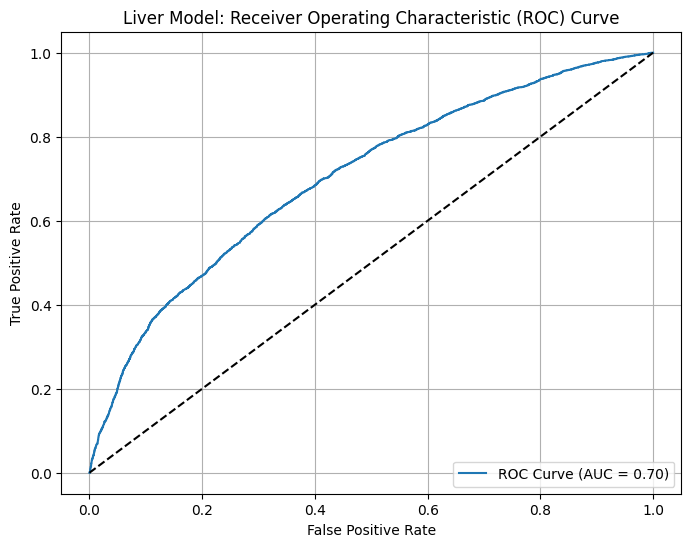

In [13]:
y_pred_liver = best_overall_liver_model.predict(X_test_liver)
y_prob_liver = best_overall_liver_model.predict_proba(X_test_liver)[:, 1]

print("\nLiver Model - Classification Report:")
print(classification_report(y_test_liver, y_pred_liver))
print("Liver Model - Confusion Matrix:")
print(confusion_matrix(y_test_liver, y_pred_liver))
liver_test_auc = roc_auc_score(y_test_liver, y_prob_liver)
print("Liver Model - Test ROC AUC:", liver_test_auc)

# Plot ROC Curve.
fpr_liver, tpr_liver, _ = roc_curve(y_test_liver, y_prob_liver)
plt.figure(figsize=(8,6))
plt.plot(fpr_liver, tpr_liver, label=f'ROC Curve (AUC = {liver_test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Liver Model: Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# **Integration with Unsupervised Matching for Liver**

In [14]:
def get_liver_ranked_matches(query_index, n_matches=5):
    """
    Given a query index from the full scaled liver candidate features DataFrame,
    returns the top n_matches (excluding the query itself) along with their Euclidean distances.
    """
    # We assume that we use the liver candidate features from X_liver_candidate_scaled_df (created in Cell 5)
    matching_features_liver = X_liver_candidate_scaled_df.copy()  # If needed, drop any clustering column if present.
    nn_model_liver = NearestNeighbors(n_neighbors=n_matches+1, algorithm='auto')
    nn_model_liver.fit(matching_features_liver)
    distances, indices = nn_model_liver.kneighbors(matching_features_liver.iloc[[query_index]])
    neighbors_df_liver = pd.DataFrame({
        'Neighbor_Index': indices[0],
        'Distance': distances[0]
    })
    ranked_matches_liver = neighbors_df_liver[neighbors_df_liver['Distance'] > 0].reset_index(drop=True)
    return ranked_matches_liver

# Demonstrate for a sample record in the liver dataset.
query_index_example_liver = 1000
liver_matches_example = get_liver_ranked_matches(query_index_example_liver, n_matches=5)
print(f"\nRanked matches for liver record index {query_index_example_liver}:")
display(liver_matches_example)



Ranked matches for liver record index 1000:


,Neighbor_Index,Distance
0,29067,0.058367
1,50194,0.059432
2,31796,0.063982
3,9155,0.066964
4,30208,0.068374


# **Saving Liver Models and Key Objects**

In [15]:
joblib.dump(best_overall_liver_model, '/content/best_liver_model_pipeline.pkl')
print("Saved best liver model pipeline as 'best_liver_model_pipeline.pkl'.")

# Save the liver candidate scaler and clustering model.
joblib.dump(scaler_liver, '/content/scaler_liver_candidate_features.pkl')
joblib.dump(liver_kmeans, '/content/liver_kmeans_model.pkl')
joblib.dump(X_liver_candidate.columns.tolist(), '/content/liver_candidate_feature_columns.pkl')
print("Saved liver candidate features scaler, clustering model, and feature column names.")


Saved best liver model pipeline as 'best_liver_model_pipeline.pkl'.
Saved liver candidate features scaler, clustering model, and feature column names.
